In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KernelDensity

from matplotlib import pyplot as plt
%matplotlib inline
class RegressorConditional:
    def get_o_cat(self, o):
        return np.sum([o>pct for pct in self.percentiles], axis=0)
    def __init__(self, model=ExtraTreesRegressor(
        n_estimators=500, n_jobs=-1, bootstrap=True, oob_score=True)):
        self.model = model
    def fit(self, X, y):
        targ = np.where(y>=0, np.log(1+np.abs(y)), -np.log(1+np.abs(y)))
        self.model.fit(X, targ)
        o = self.model.oob_prediction_
        self.percentiles = np.percentile(o, list(range(10, 100, 10)))
        o_cat = self.get_o_cat(o)
        self.dist = {}
        for oc in range(len(self.percentiles) + 1):
            filt = [oi==oc for oi in o_cat]
            kde = KernelDensity(kernel='exponential', metric='manhattan', bandwidth=0.3)
            kde.fit(list(zip(y[filt])))
            self.dist[oc] = np.exp(kde.score_samples(list(zip(range(-99, 100)))))
            self.dist[oc] /= sum(self.dist[oc])
    def predict_proba(self, X):
        o = self.model.predict(X)
        o_cat = self.get_o_cat(o)
        return np.array([self.dist[oc] for oc in o_cat])


In [2]:
pd.set_option('max_columns', None)

In [3]:
def get_crps(y_pred, y_valid):
    y_valid = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
    val_s = ((y_valid - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * X_test.shape[0])
    crps = np.round(val_s, 6)
    return crps

In [4]:

from keras.layers import Dense,Input,Flatten,concatenate,Dropout,Lambda,BatchNormalization
from keras.models import Model
import keras.backend as K
from keras.callbacks import Callback
from  keras.callbacks import EarlyStopping,ModelCheckpoint
import datetime
from sklearn.model_selection import train_test_split, KFold
import time
class CRPSCallback(Callback):
    
    def __init__(self,validation, predict_batch_size=20, include_on_batch=False):
        super(CRPSCallback, self).__init__()
        self.validation = validation
        self.predict_batch_size = predict_batch_size
        self.include_on_batch = include_on_batch
        
        print('validation shape',len(self.validation))

    def on_batch_begin(self, batch, logs={}):
        pass

    def on_train_begin(self, logs={}):
        if not ('CRPS_score_val' in self.params['metrics']):
            self.params['metrics'].append('CRPS_score_val')

    def on_batch_end(self, batch, logs={}):
        if (self.include_on_batch):
            logs['CRPS_score_val'] = float('-inf')

    def on_epoch_end(self, epoch, logs={}):
        logs['CRPS_score_val'] = float('-inf')
            
        if (self.validation):
            X_valid, y_valid = self.validation[0], self.validation[1]
            y_pred = self.model.predict(X_valid)
            y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
            y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
            val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * X_valid.shape[0])
            val_s = np.round(val_s, 6)
            logs['CRPS_score_val'] = val_s
    
def get_model(x_tr,y_tr,x_val,y_val,step):
    inp = Input(shape = (x_tr.shape[1],))
    x = Dense(1024, input_dim=x_tr.shape[1], activation='relu')(inp)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    out = Dense(199, activation='softmax')(x)
    model = Model(inp,out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[])
    
    es = EarlyStopping(monitor='CRPS_score_val', 
                       mode='min',
                       restore_best_weights=True, 
                       verbose=1, 
                       patience=20)

    mc = ModelCheckpoint('best_model_{}.h5'.format(step),monitor='CRPS_score_val',mode='min',
                                   save_best_only=True, verbose=1, save_weights_only=True)
    
    bsz = 1024
    steps = x_tr.shape[0]/bsz
    


    hist = model.fit(x_tr, y_tr,callbacks=[CRPSCallback(validation = (x_val,y_val)),es,mc], epochs=150, batch_size=bsz,verbose=1)
    model.load_weights('best_model_{}.h5'.format(step))
    
    y_pred = model.predict(x_val)
    y_valid = y_val
    crps = get_crps(y_pred, y_valid)

    return model, crps, hist


Using TensorFlow backend.


In [5]:
df = pd.read_csv('../input/nfl-big-data-bowl-2020/train.csv', low_memory=False).select_dtypes(include=np.number)
df_play = df[df.NflId==df.NflIdRusher].copy()
features = df_play.drop('Yards', axis=1).select_dtypes(include=np.number).columns.tolist()

In [28]:
df_play.head(3)

,GameId,PlayId,X,Y,S,A,Dis,Orientation,Dir,NflId,JerseyNumber,Season,YardLine,Quarter,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,DefendersInTheBox,Yards,PlayerWeight,Week,Temperature,Humidity
18,2017090700,20170907000118,78.75,30.53,3.63,3.35,0.38,161.98,245.74,2543773,28,2017,35,1,3,2,0,0,2543773,6.0,8,205,1,63.0,77.0
40,2017090700,20170907000139,71.07,27.16,3.06,2.41,0.34,210.70,312.20,2543773,28,2017,43,1,1,10,0,0,2543773,6.0,3,205,1,63.0,77.0
62,2017090700,20170907000189,48.66,19.11,5.77,2.42,0.60,140.82,221.96,2543773,28,2017,35,1,1,10,0,0,2543773,7.0,5,205,1,63.0,77.0


In [ ]:
from sklearn.model_selection import train_test_split
X = df_play[features].fillna(-999)
y = df_play.Yards
X = X.drop(['GameId', 'PlayId', 'Season'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=True)
y_valid = np.zeros((y_test.shape[0], 199))
for idx, target in enumerate(list(y_test)):
    y_valid[idx][99 + target] = 1


In [51]:
model = RegressorConditional()
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
crps = get_crps(y_pred, y_valid)
print(crps)

0.013324


In [52]:
y_pred_reg = y_pred

In [46]:
y_true = np.zeros((y_train.shape[0], 199))
for idx, target in enumerate(list(y_train)):
    y_true[idx][99 + target] = 1
model,crps, hist = get_model(X_train,y_true,
                             X_test,y_valid,1)
print(crps)

validation shape 2
Epoch 1/150
18536/18536 [==============================] - 1s 53us/step - loss: 5.6718

Epoch 00001: CRPS_score_val improved from inf to 0.07327, saving model to best_model_1.h5
Epoch 2/150
18536/18536 [==============================] - 0s 6us/step - loss: 5.3259

Epoch 00002: CRPS_score_val improved from 0.07327 to 0.06293, saving model to best_model_1.h5
Epoch 3/150
18536/18536 [==============================] - 0s 7us/step - loss: 4.9110

Epoch 00003: CRPS_score_val improved from 0.06293 to 0.04642, saving model to best_model_1.h5
Epoch 4/150
18536/18536 [==============================] - 0s 6us/step - loss: 4.3266

Epoch 00004: CRPS_score_val did not improve from 0.04642
Epoch 5/150
18536/18536 [==============================] - 0s 10us/step - loss: 3.7028

Epoch 00005: CRPS_score_val did not improve from 0.04642
Epoch 6/150
18536/18536 [==============================] - 0s 7us/step - loss: 3.3577

Epoch 00006: CRPS_score_val did not improve from 0.04642
Epoch 7/

18536/18536 [==============================] - 0s 10us/step - loss: 2.9415

Epoch 00053: CRPS_score_val did not improve from 0.01434
Epoch 54/150
18536/18536 [==============================] - 0s 9us/step - loss: 2.9445

Epoch 00054: CRPS_score_val did not improve from 0.01434
Epoch 55/150
18536/18536 [==============================] - 0s 8us/step - loss: 2.9446

Epoch 00055: CRPS_score_val did not improve from 0.01434
Epoch 56/150
18536/18536 [==============================] - 0s 9us/step - loss: 2.9398

Epoch 00056: CRPS_score_val improved from 0.01434 to 0.01434, saving model to best_model_1.h5
Epoch 57/150
18536/18536 [==============================] - 0s 16us/step - loss: 2.9332

Epoch 00057: CRPS_score_val improved from 0.01434 to 0.01418, saving model to best_model_1.h5
Epoch 58/150
18536/18536 [==============================] - 0s 11us/step - loss: 2.9263

Epoch 00058: CRPS_score_val did not improve from 0.01418
Epoch 59/150
18536/18536 [==============================] - 0s 9us

In [49]:
y_pred_nn = model.predict(X_test)

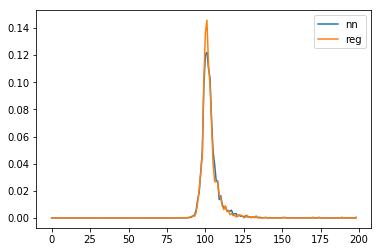

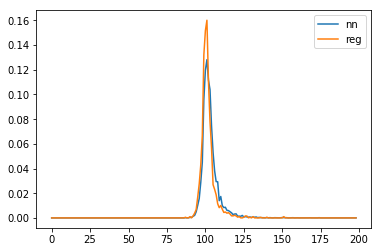

In [68]:
plt.plot(y_pred_nn[0], label='nn')
plt.plot(y_pred_reg[0], label='reg')
plt.legend()
plt.show()
plt.plot(y_pred_nn[1], label='nn')
plt.plot(y_pred_reg[1], label='reg')
plt.legend()
plt.show()

In [66]:
sum(sum(y_pred_nn)), sum(sum(y_pred_reg))

(4634.953757803887, 4635.0000000000155)